# Pulsar Classification Analysis

# Imports

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline as iPipeline

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

# Functions

In [33]:
def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()

def check_for_dupes_nans(df:pd.DataFrame):
    """
    Checks for dupes and nulls
    """
    amount_of_dupes = df.duplicated().sum()
    print(f"Null Count: {df.isna().sum()}")
    print(f"Dupe Count: {amount_of_dupes}")

def create_model_performance_visual(df, y):
    fig, ax = plt.subplots(figsize=(10, 6)) 

    df.plot.bar(x='Model', y=y, ax=ax)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title("Model Performance Comparison", fontsize=16)

    ax.legend(y)
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.show()


def create_confusion_matrix(model_name:str, y_test:pd.Series, y_test_pred:pd.Series):
    """
    This function displays a classificaiton report
    & a Confusion Matrix

    Args:
        model_name (str): _description_
        y_test (pd.Series): _description_
        y_test_pred (pd.Series): _description_
    """
    
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test,y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix {model_name}')
    plt.show()

def create_pipeline(model):
    
    pipeline = Pipeline(steps=[
        ("Scaler", MinMaxScaler()), 
         ("Power_Transformer", PowerTransformer()),
         ("model", model)
        ])
    return pipeline
    

def evaluate_model(X:pd.Series, y:pd.Series, model):
    """
    This function takes in X, y values
    scores model performance based on
    subsets of data

    Returns:
        scores of models
    """
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    metric = make_scorer(f1_score)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series, sampled=False, sampling_model=None):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    model_performance = []
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        if sampled:
            pipeline = model
        else:
            pipeline = create_pipeline(model)
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": model_name,
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    performance_df = performance_df.sort_values(by="Mean", ascending=False)
    create_model_performance_visual(performance_df, ["Mean", "STD"])
    print(performance_df)

def get_over_sampling_methods(name, X,y):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  sampling_model = sampling_models[name]
  
  pipeline = iPipeline(steps=[
      ("Scaler", MinMaxScaler()),
      ("PowerTransformer", PowerTransformer()),
      ("model", sampling_model)
      ])
  X_res, y_res = pipeline.fit_resample(X, y)
  return (X_res, y_res)

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/Pulsar_cleaned.csv")
df

,Mean_Integrated,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,1.502969,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,0.788423,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,0.323558,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,0.958983,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,1.232198,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...
14982,96.000000,0.537495,0.281344,1.871237,15.833746,9.634927,104.821623,0
14983,136.429688,1.349991,-0.738123,1.296823,12.166062,15.450260,285.931022,0
14984,122.554688,0.316006,0.323061,16.409699,44.626893,2.945244,8.297092,0
14985,119.335938,0.213253,-0.743025,21.430602,58.872000,2.499517,4.595173,0


# Check for Dupes and Nulls

In [6]:
check_for_dupes_nans(df)

Null Count: Mean_Integrated         0
EK                      0
Skewness                0
Mean_DMSNR_Curve        0
SD_DMSNR_Curve          0
EK_DMSNR_Curve          0
Skewness_DMSNR_Curve    0
Class                   0
dtype: int64
Dupe Count: 0


# Check for class Imbalance

Class=0, Count=14679, Percentage=97.945%
Class=1, Count=308, Percentage=2.055%


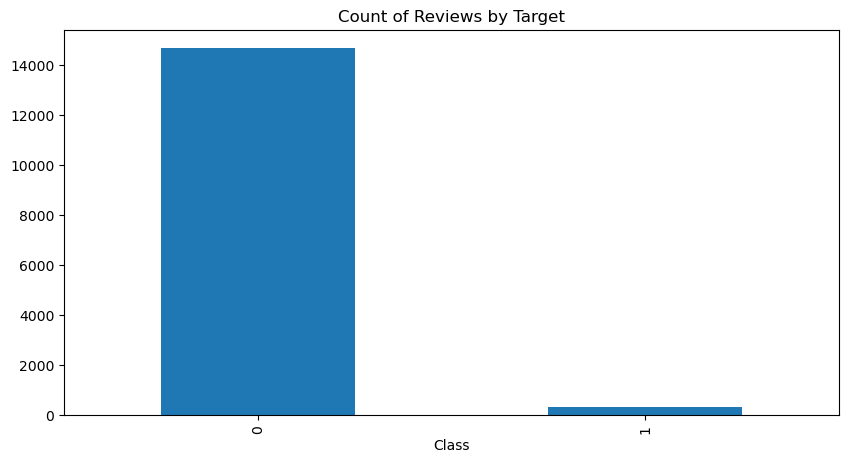

In [8]:
check_class_imbalance(df, df['Class'], "Class")

# We have a severe class imbalance which will require over sampling methods in order to properly evaluate our model.

In [9]:
df.dtypes

Mean_Integrated         float64
EK                      float64
Skewness                float64
Mean_DMSNR_Curve        float64
SD_DMSNR_Curve          float64
EK_DMSNR_Curve          float64
Skewness_DMSNR_Curve    float64
Class                     int64
dtype: object

In [10]:
df.describe()

,Mean_Integrated,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
count,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000,14987.000000
mean,115.941758,0.768933,0.389529,3.775272,20.419064,8.965458,106.490589,0.020551
std,16.790736,0.639350,0.880771,4.052198,9.324754,3.100184,72.938789,0.141881
min,39.976562,0.000038,-1.207550,0.650502,9.956068,-0.649044,-1.630794,0.000000
25%,104.734375,0.296824,-0.201098,1.890886,14.285618,6.941751,53.175677,0.000000
50%,116.554688,0.636305,0.148028,2.600334,17.478642,8.832803,92.117154,0.000000
75%,127.617188,1.080049,0.697814,3.896739,23.119246,10.813328,142.364947,0.000000
max,186.023438,6.335349,4.238586,79.635452,62.141842,18.535485,364.501595,1.000000


# Visuals

<AxesSubplot:>

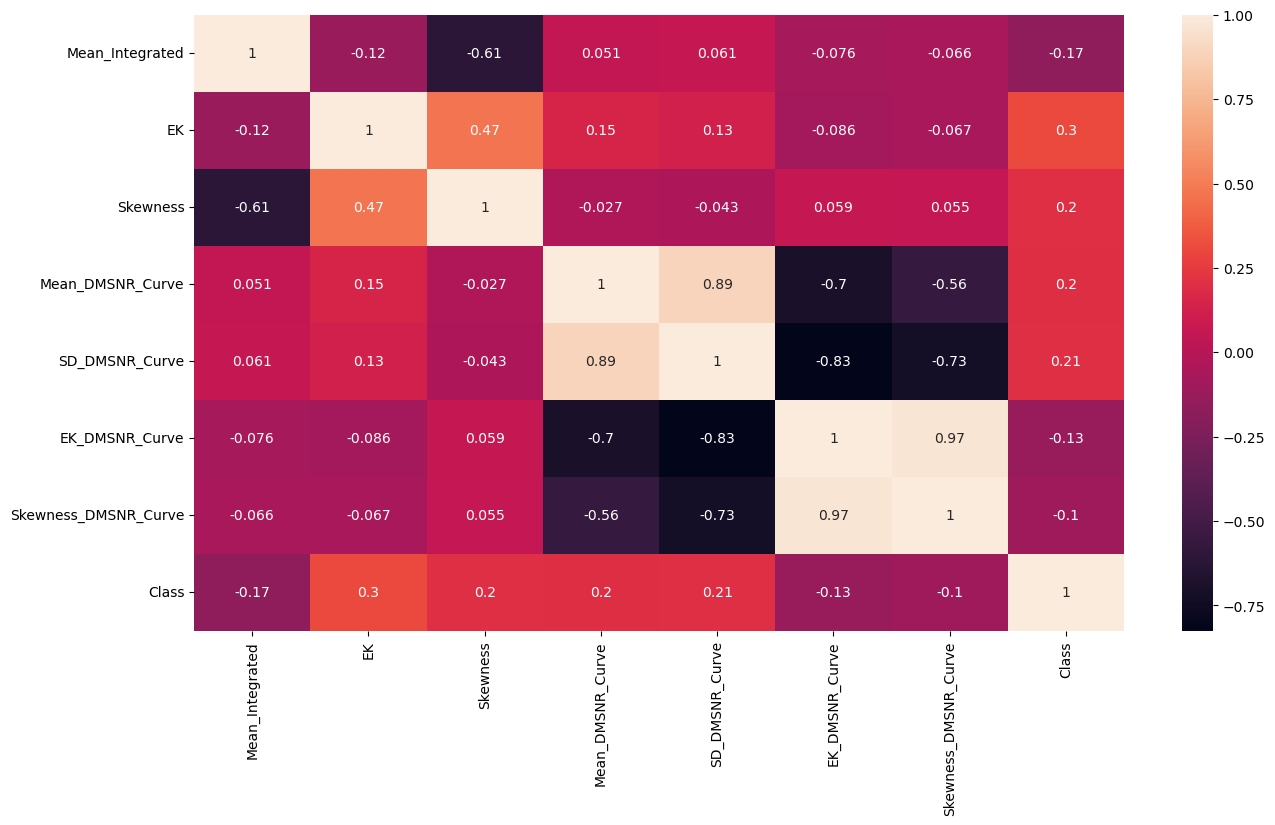

In [13]:
plt.figure(figsize=(15, 8))
sns.heatmap(data=df.corr(), annot=True)

# Distribution Check

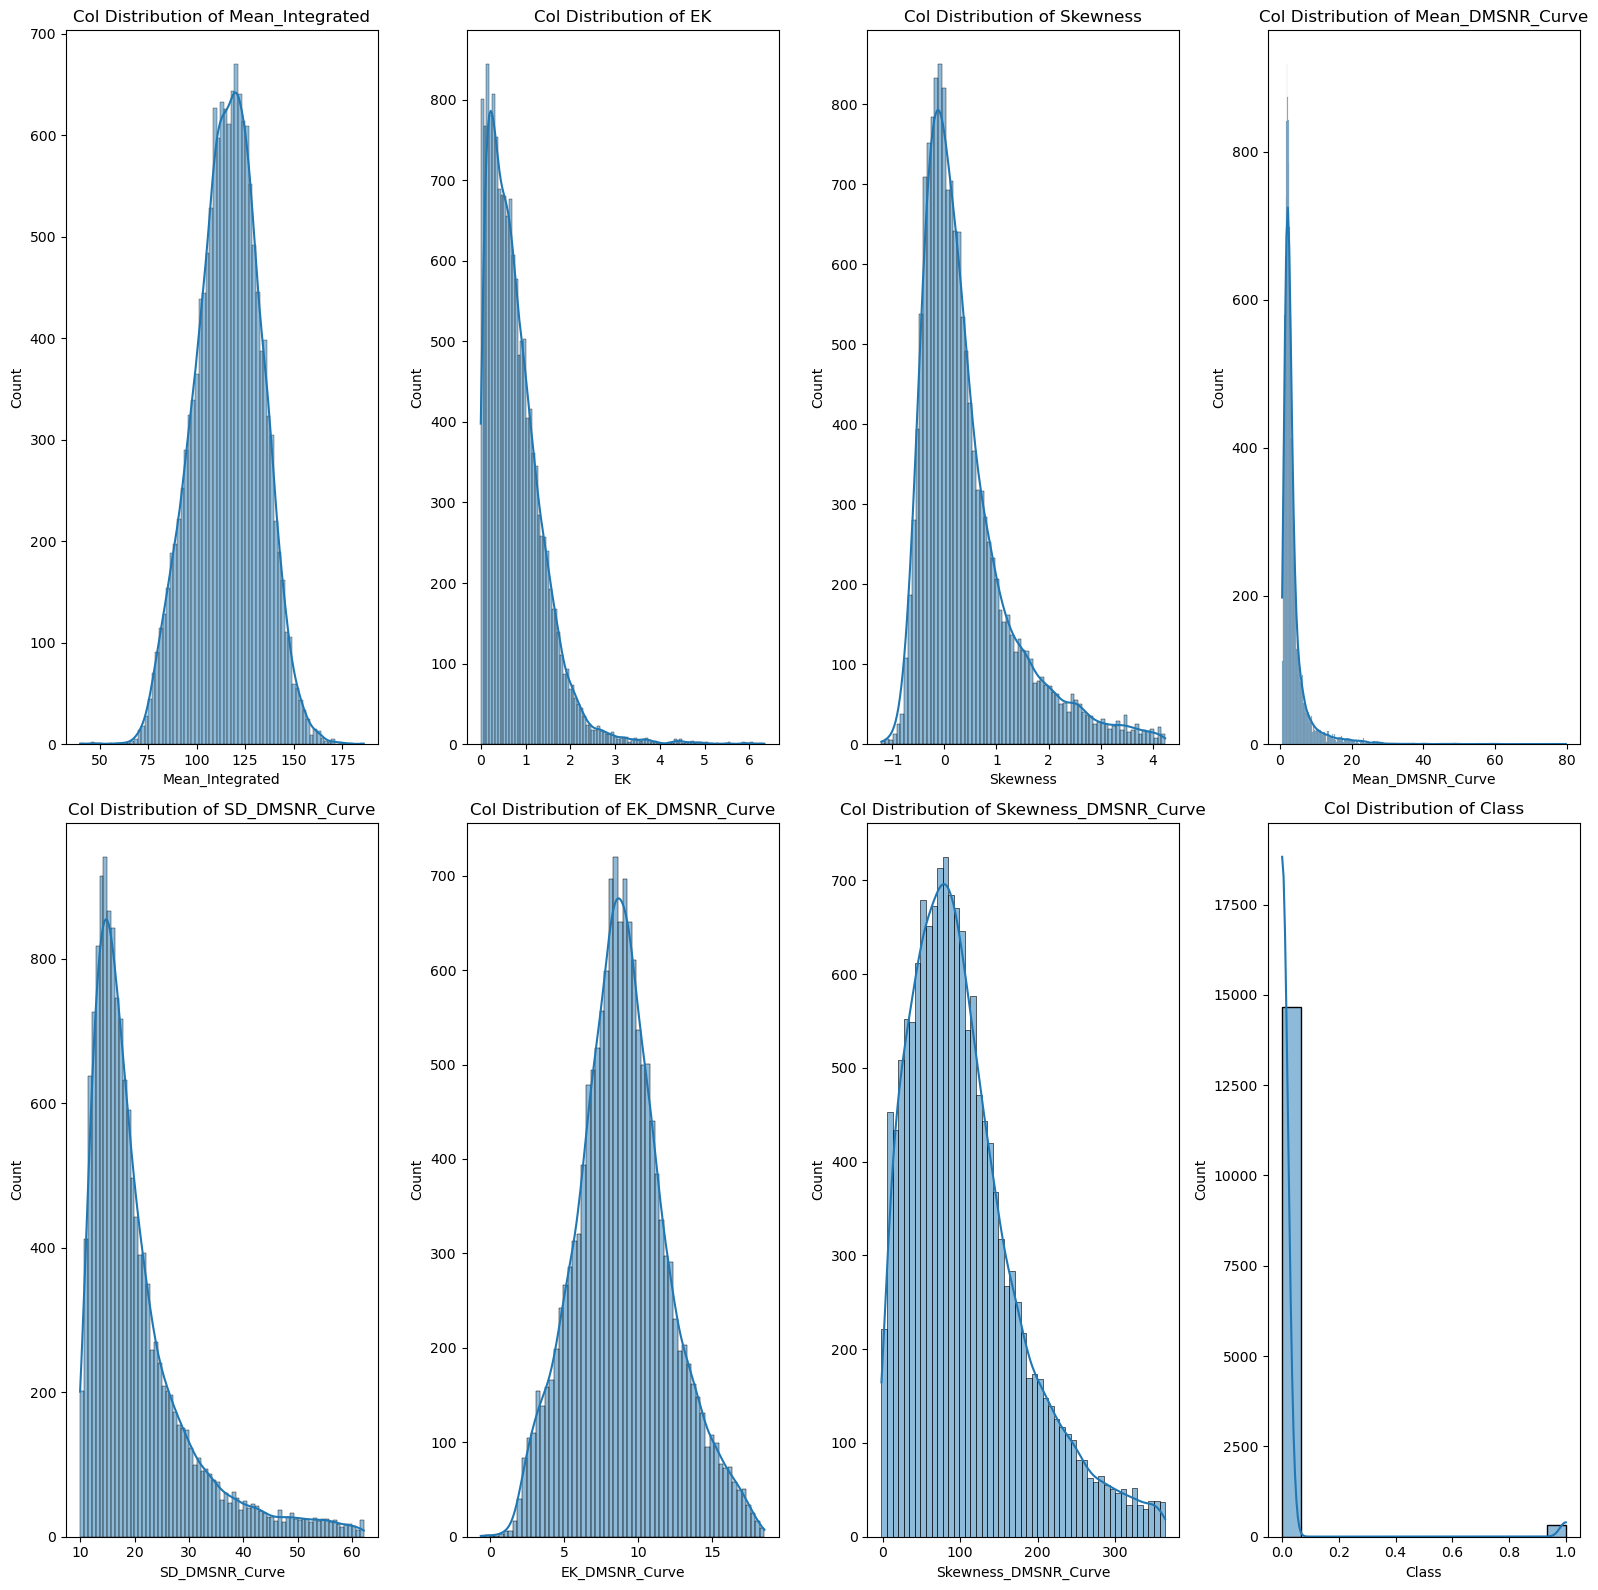

In [17]:
plt.figure(figsize=(16, 16))
col_values = len(df.columns)
rows_per_subplot = (col_values +3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(rows_per_subplot, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Col Distribution of {col}")
  plt.tight_layout()
  plt.plot()

# Outlier Check

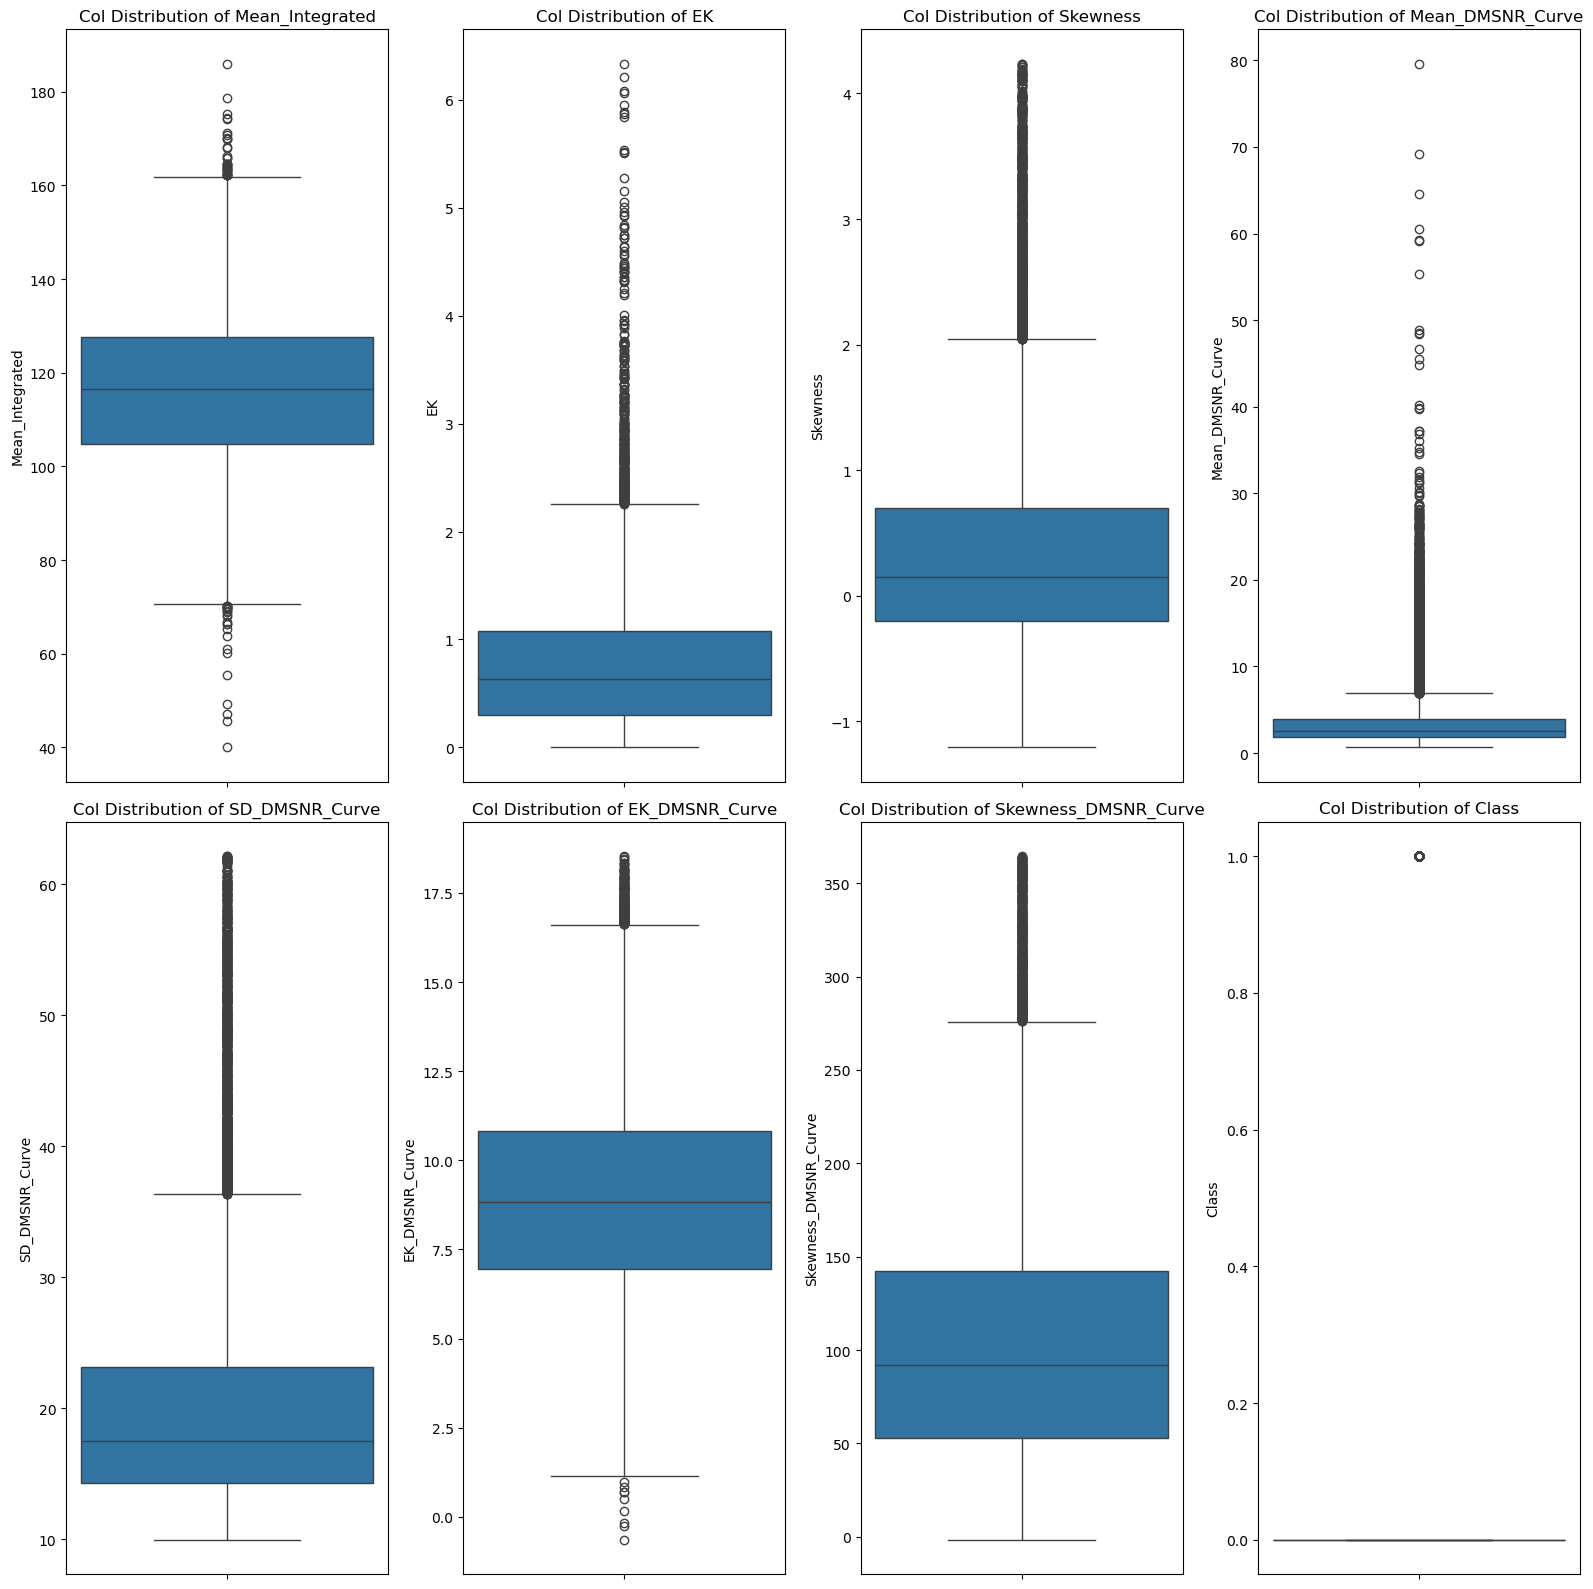

In [18]:
plt.figure(figsize=(16, 16))
col_values = len(df.columns)
rows_per_subplot = (col_values +3)//4

for idx, col in enumerate(df.columns):
  plt.subplot(rows_per_subplot, 4, idx+1)
  sns.boxplot(df[col])
  plt.title(f"Col Distribution of {col}")
  plt.tight_layout()
  plt.plot()

# Outliers exist in the dataset, we may need to implore distribution techniques in order to get into reduce the impact of these outliers

# Separate feature variables

In [19]:
X,y = df.drop("Class", axis=1), df["Class"]

# Baseline Model Evaluation

In [20]:
model = DummyClassifier(strategy="constant", constant=1)
scores = evaluate_model(X,y, model)
print('Mean F1: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean F1: 0.040 (0.000)


# This test was done on data that is not scaled properly. Lets scale our data and test again.

# Advanced Model Metrics

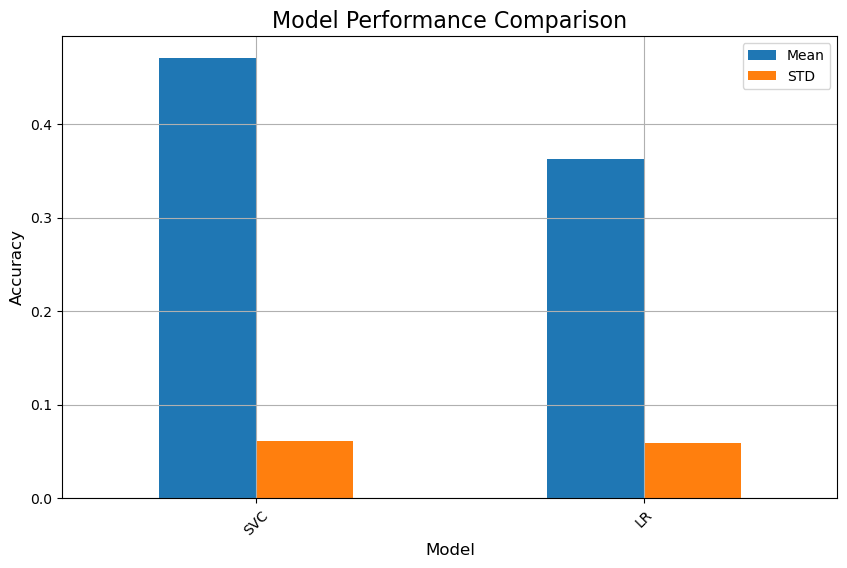

  Model      Mean       STD
1   SVC  0.470675  0.060829
0    LR  0.362844  0.059380


In [30]:
model_names = ["LR", "SVC"]
models = get_selected_models(model_names)
testing_selected_models(model_names, models, X, y, sampled=False)

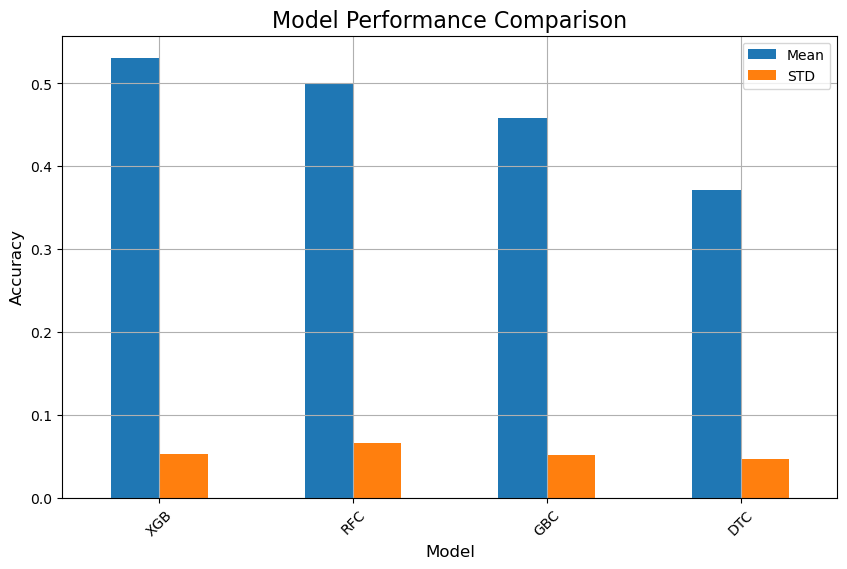

  Model      Mean       STD
3   XGB  0.531017  0.053147
1   RFC  0.500203  0.066169
2   GBC  0.457732  0.051085
0   DTC  0.370919  0.046361


In [31]:
model_names = ["DTC", "RFC", "GBC", "XGB"]
models = get_selected_models(model_names)
testing_selected_models(model_names, models, X, y, sampled=False)

# Test sampling methods

# Smote

In [34]:
X_smote, y_smote = get_over_sampling_methods("SMOTE", X, y)

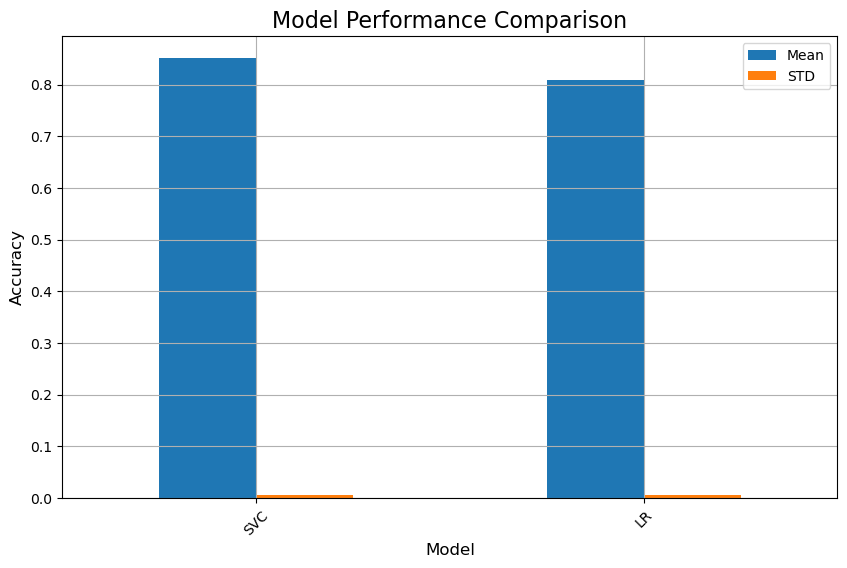

  Model      Mean       STD
1   SVC  0.851454  0.005160
0    LR  0.808989  0.006192


In [37]:
model_names = ["LR", "SVC"]
models = get_selected_models(model_names)
testing_selected_models(model_names, models, X_smote, y_smote, sampled=True)

python(16178) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16180) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16182) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16183) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16187) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16188) Malloc

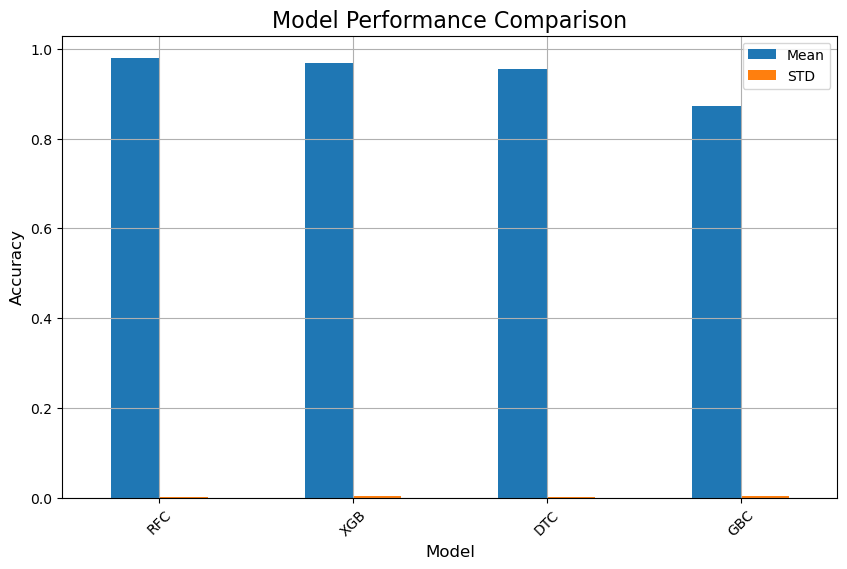

  Model      Mean       STD
1   RFC  0.980059  0.001741
3   XGB  0.967705  0.002876
0   DTC  0.954067  0.002646
2   GBC  0.873180  0.004584


In [38]:
model_names = ["DTC", "RFC", "GBC", "XGB"]
models = get_selected_models(model_names)
testing_selected_models(model_names, models, X_smote, y_smote, sampled=True)

# Borderline Sampling Method

In [39]:
X_bl, y_bl = get_over_sampling_methods("BL-SMOTE", X, y)

python(16282) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16283) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16284) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16285) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16286) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16288) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16290) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16291) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16292) Malloc

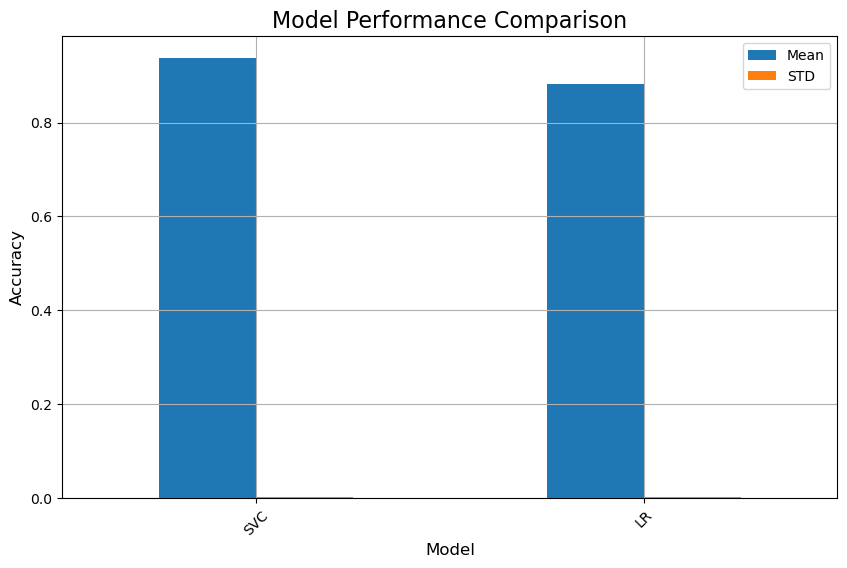

  Model      Mean       STD
1   SVC  0.937495  0.001563
0    LR  0.882404  0.003054


In [41]:
model_names = ["LR", "SVC"]
models = get_selected_models(model_names)
testing_selected_models(model_names, models, X_bl, y_bl, sampled=True)

python(16322) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16324) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16325) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16327) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16328) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16330) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16331) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


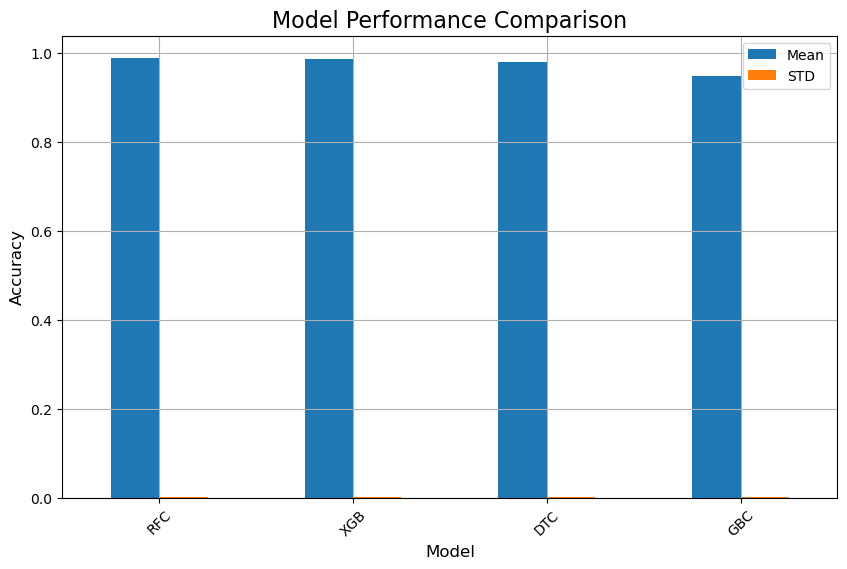

  Model      Mean       STD
1   RFC  0.989927  0.001195
3   XGB  0.985969  0.001082
0   DTC  0.979816  0.001974
2   GBC  0.949773  0.002525


In [42]:
model_names = ["DTC", "RFC", "GBC", "XGB"]
models = get_selected_models(model_names)
testing_selected_models(model_names, models, X_bl, y_bl, sampled=True)